# **NUMBER PLATE RECOGNITION. **




# **1. Import Libraries**

In [4]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf
print(tf.__version__)


2.9.2


#**2. Mount drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

# **3. Clone the tensorflow models git repository & Install TensorFlow Object Detection API**





In [ ]:
!git clone --q https://github.com/tensorflow/models.git

%cd models/research

!protoc object_detection/protos/*.proto --python_out=.

!cp object_detection/packages/tf2/setup.py .
!python -m pip install .


# **4. Test the model builder**


In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

# **5.  Unzip the *images.zip* and *annotations.zip* files.**



In [ ]:
%cd /mydrive/NumberPlateRecognition/data/

!unzip /mydrive/NumberPlateRecognition/images.zip -d .
!unzip /mydrive/NumberPlateRecognition/annotations.zip -d .

# **6 Create test_labels & train_labels**
Current working directory is /mydrive/customTF2/data/

Divide annotations into test_labels(20%) and train_labels(80%).

In [ ]:
!mkdir test_labels train_labels

!ls annotations/* | sort -R | head -85 | xargs -I{} mv {} test_labels/

!ls annotations/* | xargs -I{} mv {} train_labels/

# **7. Create the CSV files and the "label_map.pbtxt".**


In [ ]:

def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text  ,   
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[5][0].text),
               int(member[5][1].text),
               int(member[5][2].text),
               int(member[5][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)
    print('Successfully created label_map.pbtxt ')  

**8. Create train.record & test.record files**




In [ ]:
!python /mydrive/NumberPlateRecognition/generate_tfrecord.py train_labels.csv  label_map.pbtxt images/ train.record

!python /mydrive/NumberPlateRecognition/generate_tfrecord.py test_labels.csv  label_map.pbtxt images/ test.record


# **9. Download pre-trained model checkpoint** 

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# **10. Get the model pipeline config file, make changes to it and put it inside the *data* folder**


In [ ]:
!cp /content/models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config /mydrive/NumberPlateRecognition/data

# **11. Train the model** 






In [ ]:
%cd /content/models/research/object_detection

## Training using model_main_tf2.py


In [ ]:
!python model_main_tf2.py --pipeline_config_path=/mydrive/NumberPlateRecognition/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --model_dir=/mydrive/NumberPlateRecognition/training --alsologtostderr

# **12. Test model**

In [ ]:
!python exporter_main_v2.py --trained_checkpoint_dir=/mydrive/NumberPlateRecognition/training --pipeline_config_path=/content/gdrive/MyDrive/NumberPlateRecognition/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --output_directory /mydrive/NumberPlateRecognition/data/inference_graph

In [ ]:
!wget https://freefontsdownload.net/download/160187/arial.zip
!unzip arial.zip -d .

%cd utils/
!sed -i "s/font = ImageFont.truetype('arial.ttf', 24)/font = ImageFont.truetype('arial.ttf', 50)/" visualization_utils.py
%cd ..

Loading model...Done!


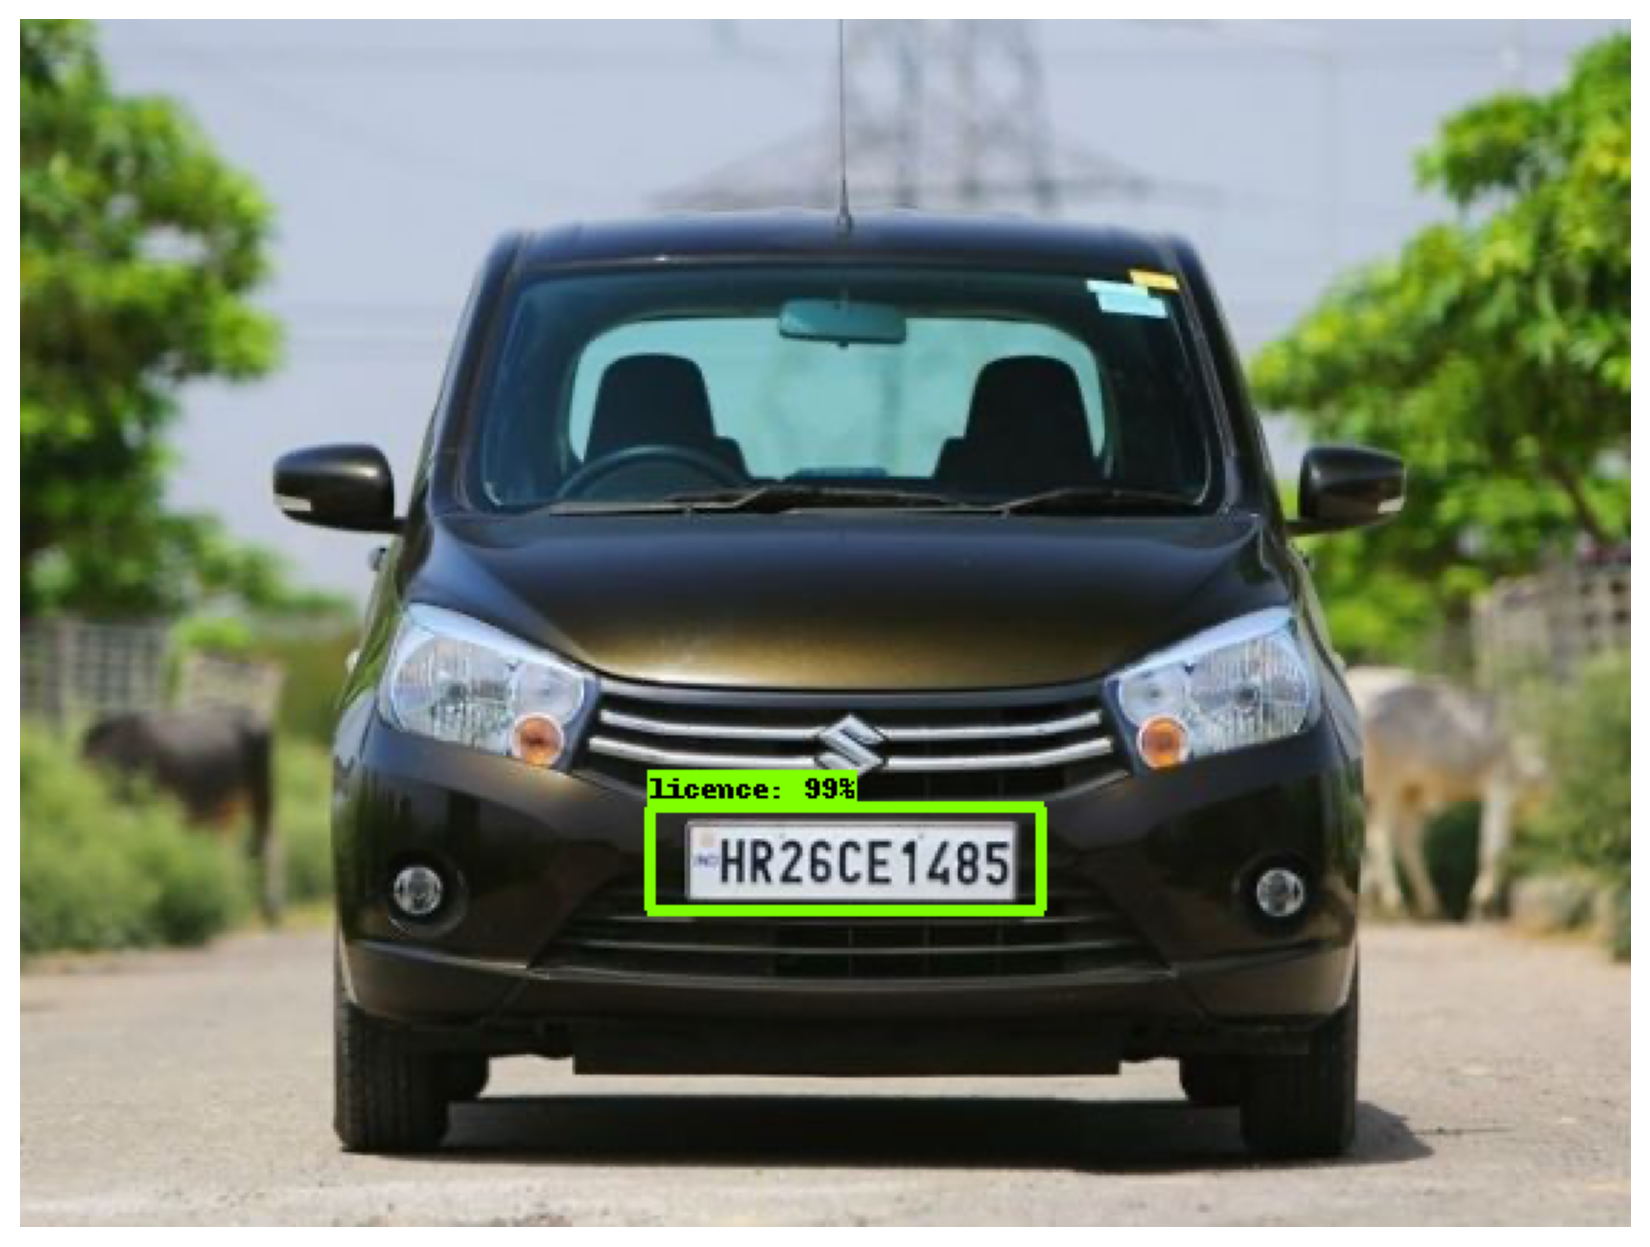

In [8]:
#Loading the saved_model
import tensorflow as tf
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

IMAGE_SIZE = (12, 8) # Output display size as you want
import matplotlib.pyplot as plt
PATH_TO_SAVED_MODEL="/mydrive/NumberPlateRecognition/data/inference_graph/saved_model"
print('Loading model...', end='')

# Load saved model and build the detection function
detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

#Loading the label_map
category_index=label_map_util.create_category_index_from_labelmap("/mydrive/NumberPlateRecognition/data/label_map.pbtxt",use_display_name=True)
#category_index=label_map_util.create_category_index_from_labelmap([path_to_label_map],use_display_name=True)

def load_image_into_numpy_array(path):

    return np.array(Image.open(path))

image_path = "/mydrive/NumberPlateRecognition/data/images/Cars372.png"
#print('Running inference for {}... '.format(image_path), end='')

image_np = load_image_into_numpy_array(image_path)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.4, # Adjust this value to set the minimum probability boxes to be classified as True
      agnostic_mode=False)
%matplotlib inline
plt.figure(figsize=IMAGE_SIZE, dpi=200)
plt.axis("off")
plt.imshow(image_np_with_detections)
plt.show()

In [ ]:
!pip install easyocr
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

136
HRZGCE 1485


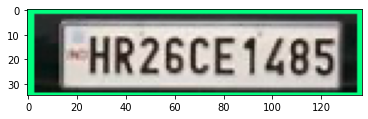

In [14]:
import easyocr
detection_threshold = 0.7
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]
width = image.shape[1]
height = image.shape[0]
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    # print(box)
    roi = box*[height, width, height, width]
    # print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    # print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
for result in ocr_result:
    print(np.sum(result[0][1]))
    print(result[1])